In [8]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
## for data
import json
import pandas as pd
import numpy as np
from sklearn import metrics, manifold
## for processing
import re
import nltk
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for w2v
import gensim
import gensim.downloader as gensim_api
## for bert
import transformers

In [9]:
lst_dics = []
with open('data.json', mode='r', errors='ignore') as json_file:
    for dic in json_file:
        lst_dics.append( json.loads(dic) )
## print the first one
lst_dics[0]

{'category': 'CRIME',
 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 'authors': 'Melissa Jeltsen',
 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
 'short_description': 'She left her husband. He killed their children. Just another day in America.',
 'date': '2018-05-26'}

In [10]:
## create dtf
dtf = pd.DataFrame(lst_dics)
## filter categories
dtf = dtf[ dtf["category"].isin(['ENTERTAINMENT','POLITICS','TECH'])        ][["category","headline"]]
## rename columns
dtf = dtf.rename(columns={"category":"y", "headline":"text"})
## print 5 random rows
dtf.sample(5)

,y,text
59122,ENTERTAINMENT,French Comedian Targets Woody Allen With Rape ...
14109,ENTERTAINMENT,Film Producers' Discussion On Weinstein Scanda...
67489,POLITICS,Panel Says LAPD Killing Of Homeless Man Was OK...
93729,POLITICS,Land Rights: One Key to Women's Economic Empow...
9953,POLITICS,White Nationalists Have Been Saying 'Diversity...


In [12]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [14]:
lst_stopwords = nltk.corpus.stopwords.words("english")
#lst_stopwords

In [15]:
dtf["text_clean"] = dtf["text"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
dtf.head()

,y,text,text_clean
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,smith join diplo nicky jam 2018 world cup offi...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,hugh grant marries first time age 57
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,jim carrey blast castrato adam schiff democrat...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,julianna margulies us donald trump poop bag pi...
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,morgan freeman devastated sexual harassment cl...


In [16]:
nlp = gensim_api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


C:\Users\USER-PC\anaconda3\envs\bert\lib\site-packages\smart_open\smart_open_lib.py:400: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  warnings.warn(


In [18]:
nlp.most_similar(["obama"], topn=3)

[('barack', 0.9254721403121948),
 ('mccain', 0.7590768337249756),
 ('bush', 0.7570987939834595)]

In [20]:
## Function to apply
def get_similar_words(lst_words, top, nlp):
    lst_out = lst_words
    for tupla in nlp.most_similar(lst_words, topn=top):
        lst_out.append(tupla[0])
    return list(set(lst_out))
## Create Dictionary {category:[keywords]}
dic_clusters = {}
dic_clusters["ENTERTAINMENT"] = get_similar_words(['celebrity','cinema','movie','music'], 
                  top=30, nlp=nlp)
dic_clusters["POLITICS"] = get_similar_words(['gop','clinton','president','obama','republican']
                  , top=30, nlp=nlp)
dic_clusters["TECH"] = get_similar_words(['amazon','android','app','apple','facebook',
                   'google','tech'], 
                   top=30, nlp=nlp)
## print some
for k,v in dic_clusters.items():
    print(k, ": ", v[0:5], "...", len(v))

ENTERTAINMENT :  ['film', 'filmmakers', 'dance', 'entertainment', 'documentary'] ... 34
POLITICS :  ['administration', 'democrats', 'lawmakers', 'bush', 'voters'] ... 35
TECH :  ['google', 'myspace', 'smartphone', 'facebook', 'blackberry'] ... 37


In [22]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')

Downloading: 100%|██████████| 232k/232k [00:00<00:00, 419kB/s]
Downloading: 100%|██████████| 28.0/28.0 [00:00<00:00, 7.00kB/s]
Downloading: 100%|██████████| 466k/466k [00:00<00:00, 886kB/s]
Downloading: 100%|██████████| 570/570 [00:00<00:00, 114kB/s]
Downloading: 100%|██████████| 536M/536M [03:02<00:00, 2.94MB/s]
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If

In [23]:
txt = "river bank"
## tokenize
idx = tokenizer.encode(txt)
print("tokens:", tokenizer.convert_ids_to_tokens(idx))
print("ids   :", tokenizer.encode(txt))
## word embedding
idx = np.array(idx)[None,:]
embedding = nlp(idx)
print("shape:", embedding[0][0].shape)
## vector of the second input word
embedding[0][0][2]

tokens: ['[CLS]', 'river', 'bank', '[SEP]']
ids   : [101, 2314, 2924, 102]
shape: (4, 768)


<tf.Tensor: shape=(768,), dtype=float32, numpy=
array([-7.05827102e-02, -6.21527553e-01, -7.02520311e-01, -2.49586985e-01,
        5.77253699e-01,  4.81010646e-01,  2.44046226e-01,  5.12865663e-01,
       -3.52891445e-01, -8.16163182e-01,  3.99641186e-01,  1.81418300e-01,
        5.12113333e-01,  1.44479722e-01, -1.42232692e+00, -1.06336966e-01,
        1.06125111e-02, -4.34668839e-01,  1.13796687e+00,  7.06452131e-02,
        6.18477285e-01,  5.76443672e-02,  2.41198197e-01,  2.96010464e-01,
       -2.22419560e-01,  2.06983462e-01,  4.50172514e-01,  1.95635647e-01,
        7.22172111e-03,  7.06085622e-01,  6.82602763e-01, -3.35965782e-01,
        4.75640535e-01,  3.38769346e-01, -1.90572962e-01, -1.12145936e+00,
       -4.32035848e-02, -1.56870484e-01,  4.73270342e-02,  3.38265628e-01,
       -4.73710716e-01, -2.87371486e-01, -6.14665225e-02,  3.93013544e-02,
       -9.84503105e-02,  5.61598176e-03,  2.15945363e-01, -3.90439332e-02,
       -7.03860760e-01,  1.26936302e-01,  2.32843421

In [25]:
## function to apply
def utils_bert_embedding(txt, tokenizer, nlp):
    idx = tokenizer.encode(txt)
    idx = np.array(idx)[None,:]  
    embedding = nlp(idx)
    X = np.array(embedding[0][0][1:-1])
    return X
## create list of news vector
lst_mean_vecs = [utils_bert_embedding(txt, tokenizer, nlp).mean(0) 
                 for txt in dtf["text_clean"]]
## create the feature matrix (n news x 768)
X = np.array(lst_mean_vecs)

<ipython-input-25-5a932de00181>:9: RuntimeWarning: Mean of empty slice.
  lst_mean_vecs = [utils_bert_embedding(txt, tokenizer, nlp).mean(0)
C:\Users\USER-PC\anaconda3\envs\bert\lib\site-packages\numpy\core\_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  def _mean(a, axis=None, dtype=None, out=None, keepdims=False, *, where=True):


In [26]:
dic_y = {k:utils_bert_embedding(v, tokenizer, nlp).mean(0) for k,v
         in dic_clusters.items()}

In [71]:
np.isnan(X).any()

True

In [73]:
X = np.nan_to_num(X)
np.isnan(X).any()

False

In [95]:
for i, value in dic_y.items():
    dic_y[i] = value.reshape(1, -1)

In [96]:
#--- Model Algorithm ---#
## compute cosine similarities
similarities = np.array(
            [metrics.pairwise.cosine_similarity(X, y).T.tolist()[0] 
             for y in dic_y.values()]
            ).T
## adjust and rescale
labels = list(dic_y.keys())
for i in range(len(similarities)):
    ### assign randomly if there is no similarity
    if sum(similarities[i]) == 0:
       similarities[i] = [0]*len(labels)
       similarities[i][np.random.choice(range(len(labels)))] = 1
    ### rescale so they sum = 1
    similarities[i] = similarities[i] / sum(similarities[i])

## classify the label with highest similarity score
predicted_prob = similarities
predicted = [labels[np.argmax(pred)] for pred in predicted_prob]

Accuracy: 0.61
Auc: 0.83
Detail:
               precision    recall  f1-score   support

ENTERTAINMENT       0.45      0.89      0.60     16058
     POLITICS       0.92      0.49      0.64     32739
         TECH       0.36      0.37      0.37      2082

     accuracy                           0.61     50879
    macro avg       0.58      0.58      0.53     50879
 weighted avg       0.75      0.61      0.61     50879



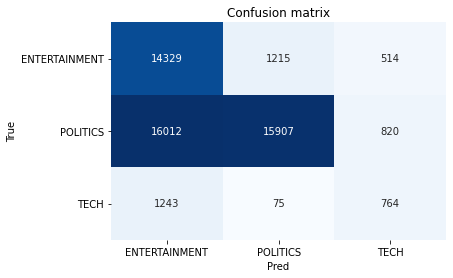

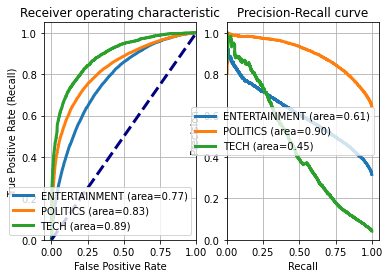

In [97]:
y_test = dtf["y"].values
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
fig, ax = plt.subplots(nrows=1, ncols=2)

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [99]:
i = 7
txt_instance = dtf["text_clean"].iloc[i]
print("True:", y_test[i], "--> Pred:", predicted[i], "| Similarity:", round(np.max(predicted_prob[i]),2))
print(txt_instance)

True: ENTERTAINMENT --> Pred: ENTERTAINMENT | Similarity: 0.38
mike myers reveals hed like fourth austin power film
